Please upload the Excel file containing log DPI data:


Saving Examen 21.1.xlsx to Examen 21.1.xlsx

Columns in the file: ['TIME', 'MONEY']
Enter the column name containing log DPI data: MONEY


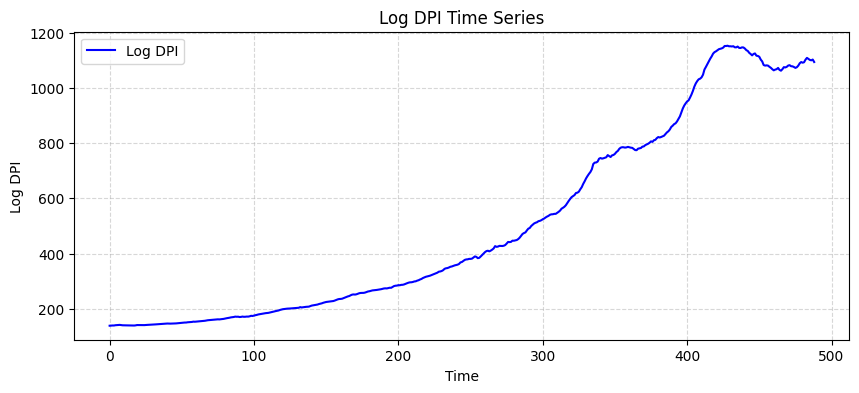


Testing Log DPI for stationarity:
ADF Statistic: -0.4674
p-value: 0.8982
Critical 1%: -3.4440
Critical 5%: -2.8676
Not Stationary - Consider differencing

Testing Differenced Log DPI for stationarity:
ADF Statistic: -2.8794
p-value: 0.0478
Critical 1%: -3.4440
Critical 5%: -2.8676
Stationary


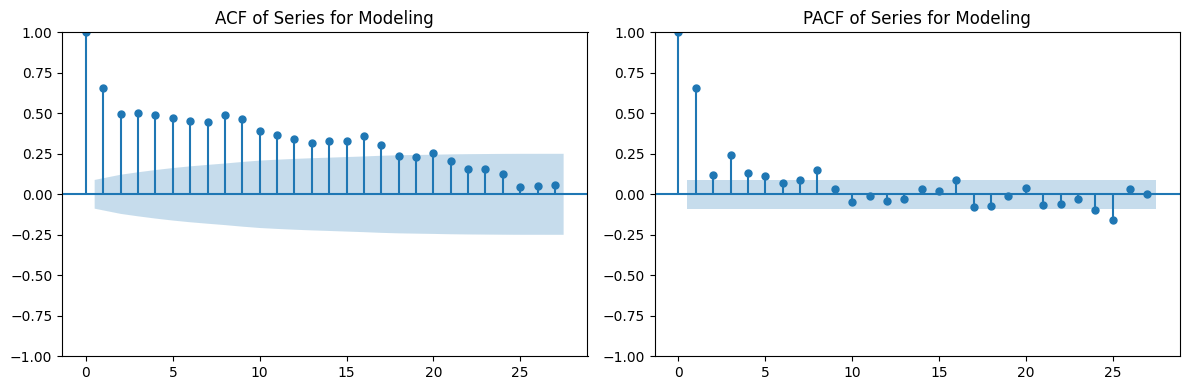

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/st


Best ARIMA order: (1, 1, 2), AIC: 2300.51

Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  MONEY   No. Observations:                  489
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -1146.257
Date:                Fri, 14 Mar 2025   AIC                           2300.514
Time:                        17:38:09   BIC                           2317.275
Sample:                             0   HQIC                          2307.097
                                - 489                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9775      0.008    117.692      0.000       0.961       0.994
ma.L1         -0.4575      0.034    -13.409      0.000      -0.524      

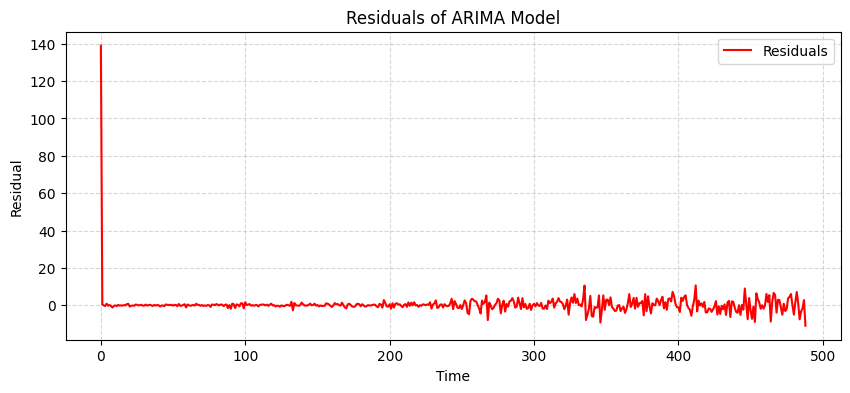

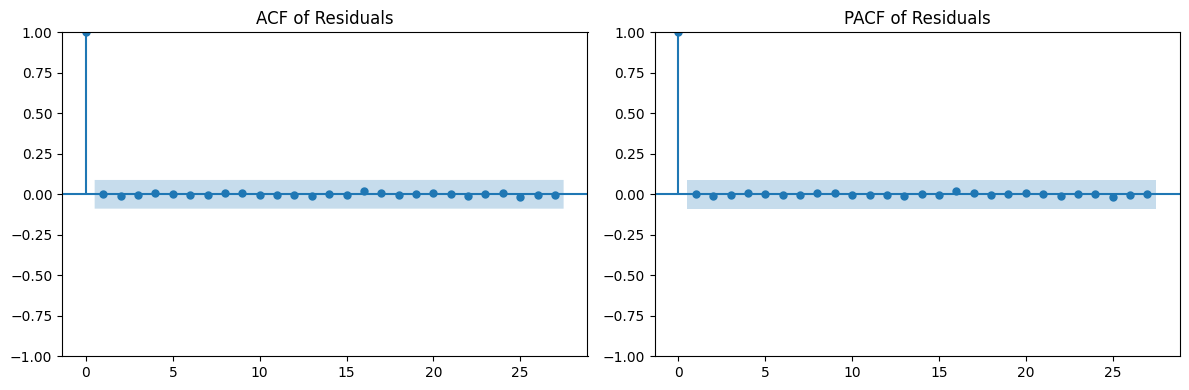

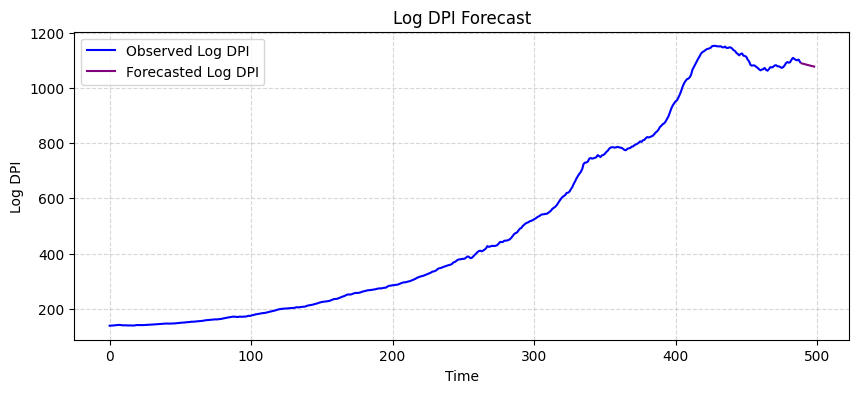


Forecasted Values:
        Forecast
489  1088.923505
490  1087.477406
491  1086.063785
492  1084.681912
493  1083.331074
494  1082.010573
495  1080.719729
496  1079.457876
497  1078.224362
498  1077.018551


In [1]:
# Ensure statsmodels is up-to-date
!pip install --upgrade statsmodels

# Load essential packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Function to load data from an uploaded Excel file
def load_data():
    print("Please upload the Excel file containing log DPI data:")
    uploaded = files.upload()
    file_key = next(iter(uploaded))  # Get the name of the uploaded file dynamically
    df = pd.read_excel(file_key)
    print("\nColumns in the file:", df.columns.tolist())
    col_name = input("Enter the column name containing log DPI data: ")
    return df[col_name].dropna().reset_index(drop=True)

# Stationarity test
def check_stationarity(series, label):
    print(f"\nTesting {label} for stationarity:")
    result = adfuller(series)
    stats = {'ADF Statistic': result[0], 'p-value': result[1],
             'Critical 1%': result[4]['1%'], 'Critical 5%': result[4]['5%']}
    for key, value in stats.items():
        print(f"{key}: {value:.4f}")
    print("Stationary" if result[1] < 0.05 else "Not Stationary - Consider differencing")
    return result[1]

# Function to plot ACF and PACF
def plot_acf_pacf(series, title):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plot_acf(series, ax=plt.gca(), title=f"ACF of {title}")
    plt.subplot(1, 2, 2)
    plot_pacf(series, ax=plt.gca(), title=f"PACF of {title}")
    plt.tight_layout()
    plt.show()

# ARIMA model selection (simple grid search for p, d, q)
def optimize_arima(series, p_range=3, d_range=2, q_range=3):
    best_aic = float('inf')
    best_order = (0, 0, 0)
    for p in range(p_range):
        for d in range(d_range):
            for q in range(q_range):
                try:
                    model = ARIMA(series, order=(p, d, q)).fit()
                    if model.aic < best_aic:
                        best_aic = model.aic
                        best_order = (p, d, q)
                except:
                    continue
    print(f"\nBest ARIMA order: {best_order}, AIC: {best_aic:.2f}")
    return best_order

# Main execution
# Step 1: Load the data
log_dpi_series = load_data()

# Step 2: Visualize the data
plt.figure(figsize=(10, 4))
plt.plot(log_dpi_series, color='blue', label='Log DPI')
plt.title("Log DPI Time Series")
plt.xlabel("Time")
plt.ylabel("Log DPI")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Step 3: Check stationarity
p_value = check_stationarity(log_dpi_series, "Log DPI")

# If not stationary, difference the series and recheck
if p_value >= 0.05:
    diff_series = log_dpi_series.diff().dropna()
    check_stationarity(diff_series, "Differenced Log DPI")
    series_to_model = diff_series
    d_start = 1
else:
    series_to_model = log_dpi_series
    d_start = 0

# Step 4: Plot ACF and PACF to guide parameter selection
plot_acf_pacf(series_to_model, "Series for Modeling")

# Step 5: Fit ARIMA model
best_order = optimize_arima(log_dpi_series)  # Fit on original series; differencing is handled by ARIMA
model = ARIMA(log_dpi_series, order=best_order).fit()
print("\nModel Summary:")
print(model.summary())

# Step 6: Diagnose residuals
residuals = model.resid
plt.figure(figsize=(10, 4))
plt.plot(residuals, color='red', label='Residuals')
plt.title("Residuals of ARIMA Model")
plt.xlabel("Time")
plt.ylabel("Residual")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

plot_acf_pacf(residuals, "Residuals")

# Step 7: Forecast
forecast_steps = 10  # Forecast 10 periods ahead
forecast = model.forecast(steps=forecast_steps)
forecast_index = range(len(log_dpi_series), len(log_dpi_series) + forecast_steps)

plt.figure(figsize=(10, 4))
plt.plot(log_dpi_series, color='blue', label='Observed Log DPI')
plt.plot(forecast_index, forecast, color='purple', label='Forecasted Log DPI')
plt.title("Log DPI Forecast")
plt.xlabel("Time")
plt.ylabel("Log DPI")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Print forecast values
forecast_df = pd.DataFrame({'Forecast': forecast}, index=forecast_index)
print("\nForecasted Values:")
print(forecast_df)

In [ ]:
#@title Convert ipynb to HTML in Colab
# Upload ipynb
from google.colab import files
f = files.upload()

# Convert ipynb to html
import subprocess
file0 = list(f.keys())[0]
_ = subprocess.run(["pip", "install", "nbconvert"])
_ = subprocess.run(["jupyter", "nbconvert", file0, "--to", "html"])

# download the html
files.download(file0[:-5]+"html")